In [1]:
#! pip install mplhep > /dev/null
#! pip install zfit > /dev/null

In [2]:
# Following https://stackoverflow.com/a/64604031
# Importing python libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys
from pathlib import Path
from matplotlib._api import check_in_list
import pickle
import os
import tensorflow as tf

from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[1] / "py")

if module_path not in sys.path:
    sys.path.append(module_path)

2024-02-19 09:45:13.321429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 09:45:13.851561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 09:45:13.854620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 09:45:15.390500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import plot_tools
import zfit
import customPDFs
import SLSQPv2 as SLSQP_zfit

/home/carlos/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [4]:
from math import pi
from numpy import cos, sin

In [5]:
## Creating the Zfit configuration for the PDF

In [6]:
## Observables

cosThetaK = zfit.Space('cosThetaK', [-1,1])
cosThetaL = zfit.Space('cosThetaL', [-1,1])
phi = zfit.Space('phi', [0, pi])

# Defining the ranges of the variables of the observable space

combined_obs = cosThetaK * cosThetaL * phi

In [7]:
## Parameters

AFB = zfit.Parameter('AFB', 0)
FL = zfit.Parameter('FH', 0) # Changing the parameters just outside the allowed region
S39 = zfit.Parameter('S39', 0)

In [8]:
version =  zfit.__version__.split('.')
if int(version[1])>=5:
    from zfit import z
else:
    from zfit import ztf as z

class decayWidth(zfit.pdf.BasePDF):
    '''
    Decay B^0 -> K^{*0} \mu^+ \mu^-
    Funciona directamente con el parámetro de phi
    '''
    _PARAMS = ['FL', 'AFB', 'S39']

    def __init__(self, FL, AFB, S39, obs, name="angular_dist" ):
        # se debe definir los parametros a pasar a la pdf
        params = {
              'FL': FL,
              'AFB': AFB,
              'S39': S39}
        super().__init__(obs, params, name=name )#FL=FL, AFB=AFB, S3=S3, S9=S9) # params


    def _unnormalized_pdf(self, x):
        cosThetaK, cosThetaL, phi = z.unstack_x(x)

        #cos2phi = tf.math.cos(2*phi)

        FL = self.params['FL']
        AFB = self.params['AFB']
        S3 = self.params['S39']

        cosK2 = cosThetaK*cosThetaK
        cosL2 = cosThetaL*cosThetaL

        pdf = (3/4)*(1-FL)*(1-cosK2)
        pdf += FL*cosK2
        pdf += (1/4)*(1-FL)*(1-cosK2)*(2*cosL2-1)
        pdf += - FL*cosK2*(2*cosL2-1)
        pdf += S39*(1-cosK2)*(1-cosL2)*tf.math.cos(2*phi) 
        pdf += (4/3)*AFB*(1-cosK2)*cosThetaL
        #pdf += (4/3)*AFB*(1-cosK2)*cosL2 Este coseno de theta_L no debe llevar ^2
        pdf = pdf*9/(16*pi)

        return pdf

'''
0.75*(1-FL)((sin(theta_k))**2)
    +FL((cos(theta_k))**2)
    +0.25*((1-FL)((sin(theta_k))**2)*cos(2theta_l))
    -FL*((cos(theta_k))**2)cos(2theta_l)
    +S39*((sin(theta_k))**2)((sin(theta_l))**2)*cos(2phi)
    +(4/3)AFB((sin(theta_k))**2)*cos(theta_l)
'''
        
        

'\n0.75*(1-FL)((sin(theta_k))**2)\n    +FL((cos(theta_k))**2)\n    +0.25*((1-FL)((sin(theta_k))**2)*cos(2theta_l))\n    -FL*((cos(theta_k))**2)cos(2theta_l)\n    +S39*((sin(theta_k))**2)((sin(theta_l))**2)*cos(2phi)\n    +(4/3)AFB((sin(theta_k))**2)*cos(theta_l)\n'

In [9]:
decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit

In [10]:
# Mesh to plot the whole PDF

cosThetaK_np = np.linspace(-1, 1, 10)
#x_np = np.zeros(100)
cosThetaL_np = np.linspace(-1, 1, 10)
#y_np = np.zeros(100)
# Changed the range of phi to the whole integration region
phi_np = np.linspace(0, pi, 10)
#phi_np = np.ones(100) * pi/4

complete_space_list = []
for i in cosThetaK_np:
    for j in cosThetaL_np:
        for k in phi_np:
            item = (i,j,k)
            complete_space_list.append(item)
    #print(len(complete_space_list))

complete_space_np = np.array(complete_space_list).reshape(len(cosThetaK_np),len(cosThetaL_np),len(phi_np), 3)

# data_mesh_lst = list(zip(cosThetaK_np, cosThetaL_np, phi_np))

# data_mesh = np.array(data_mesh_lst)# This is not quite a mesh, but we have an ordered set

In [11]:
# Printing to check the shape of the complete_space_np narray
#complete_space_np

In [12]:
dr_pdf = decay_rate.pdf(complete_space_np)

Estimated integral error ( 3.3813909976622394e-06 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).


In [13]:
AFB.set_value(0)
FL.set_value(0)
S39.set_value(0.5)
dr_samp = decay_rate.create_sampler(1000)

In [14]:
def evaluate_validity_pdf(pdf):
    valid_pdf = True
    complete_space_list = []
    for i, _i in enumerate(cosThetaK_np):
        for j, _j in enumerate(cosThetaL_np):
            for k, _k in enumerate(phi_np):
                if pdf[i,j,k].numpy() < 0:
                    print(f"PDF invalid at")
                    print(f"cosThetaK[{i}] = {_i}")
                    print(f"cosThetaL[{j}] = {_j}")
                    print(f"phi[{k}] = {_k}")
                    print(f'value = {pdf[i,j,k].numpy()}')
                    valid_pdf = False
                    break
            if not valid_pdf:
                break
        if not valid_pdf:
            break
    #print(valid_pdf)
    return valid_pdf

#def evaluate_validity_pdf_sampler(pdf):
    # Code for function with the same logic as the last one but using
    # an error from .sampler as the flag

In [15]:
evaluate_validity_pdf(dr_pdf)

True

In [16]:
linsp_size_AFB = 21
linsp_size_FL = 21
linsp_size_S39 = 11

afb_range = [-1,1]
fl_range = [-1,1]
s39_range = [-0.5,0.5]

AFB_np = np.linspace(afb_range[0], afb_range[1], linsp_size_AFB)
FL_np = np.linspace(fl_range[0], fl_range[1], linsp_size_FL)
S39_np = np.linspace(s39_range[0], s39_range[1], linsp_size_S39)

In [17]:
# valid_list = []
# S39.set_value(0)
# for i, afb_ in enumerate(AFB_np):
#     AFB.set_value(afb_)
#     for j, fl_ in enumerate(FL_np):
#         FL.set_value(fl_)
#         decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit
#         dr_pdf = decay_rate.pdf(complete_space_np)
#         valid_list.append(evaluate_validity_pdf(dr_pdf))

In [18]:
# valid_np = np.array(valid_list).reshape(len(AFB_np), len(FL_np))
# # Testing if the array has the correct shape
# #valid_np

In [19]:
# Save the numpy arrays with values and plots on the computer
# np.save('np_arrays/afb_20_fl_20_s39-0.npy', valid_np)


In [20]:
#np.save('np_arrays/afb_range.npy', AFB_np)
#np.save('np_arrays/fl_range.npy', FL_np)
#np.save('np_arrays/s39_range.npy', S39_np)

In [21]:
valid_points_FL = []
valid_points_AFB = []

In [22]:


# for i, vnp_afb in enumerate(valid_np):
#     for j, vnp_fl in enumerate(vnp_afb):
#         if vnp_fl==True:
#             valid_points_FL.append(FL_np[j])
#             valid_points_AFB.append(AFB_np[i])

In [23]:
#valid_points_FL

In [24]:
#valid_points_AFB

In [25]:
# plt.figure(figsize=(5,5))
# plt.scatter(valid_points_AFB, valid_points_FL)
# plt.axis((-3, 3.2, -3, 3))
# plt.xlabel('$A_{FB}$')
# plt.ylabel('$F_L$')
# plt.title('$S_{39}=0$')
# plt.savefig('afb_20_fl_20_s39-0.png')
# plt.show()


In [26]:
# FL.set_value(2)
# AFB.set_value(2)
# S39.set_value(0)
# decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit
# dr_pdf = decay_rate.pdf(complete_space_np)

In [27]:
# dr_pdf.shape

In [28]:
# SUbstitute by plane plot with a plane crossing PDF=0


# plt.plot(cosThetaK_np, dr_pdf[:, 1, 0])
# plt.plot(cosThetaL_np, dr_pdf[4, :, 1])
# plt.plot(phi_np,  dr_pdf[0, 2, :])

In [29]:
def calculating_valid_pdfs(s39_val):
    s39_str = "{:.2f}".format(s39_val)
    path = f'np_arrays/afb_{afb_range[0]}_{afb_range[1]}_fl_{fl_range[0]}_{fl_range[1]}_s39-{s39_str}.npy'
    if not os.path.isfile(path):
        valid_list = []
        S39.set_value(s39_val)
        for i, afb_ in enumerate(AFB_np):
            AFB.set_value(afb_)
            for j, fl_ in enumerate(FL_np):
                FL.set_value(fl_)
                decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit
                dr_pdf = decay_rate.pdf(complete_space_np)
                valid_list.append(evaluate_validity_pdf(dr_pdf))
        valid_np = np.array(valid_list).reshape(len(AFB_np), len(FL_np))
        np.save(f'np_arrays/afb_{afb_range[0]}_{afb_range[1]}_fl_{fl_range[0]}_{fl_range[1]}_s39-{s39_str}.npy', valid_np)
    else: 
        valid_np = np.load(path)

    valid_points_FL = []
    valid_points_AFB = []
    valid_coordinates = []
    
    for i, vnp_afb in enumerate(valid_np):
        for j, vnp_fl in enumerate(vnp_afb):
            if vnp_fl==True:
                valid_points_FL.append(FL_np[j])
                valid_points_AFB.append(AFB_np[i])
                valid_coordinates.append((AFB_np[i], FL_np[j], s39_val))
    # Plotting
    plt.figure(figsize=(5,5))
    plt.scatter(valid_points_AFB, valid_points_FL)
    plt.axis((afb_range[0], afb_range[1], fl_range[0], fl_range[1]))
    plt.xlabel('$A_{FB}$')
    plt.ylabel('$F_L$')
    plt.title('$S_{39}='+str(s39_val)+'$')
    plt.savefig(f'afb_{afb_range[0]}_{afb_range[1]}_fl_{fl_range[0]}_{fl_range[1]}_s39-{s39_str}.png')
    plt.show()

    return valid_coordinates 

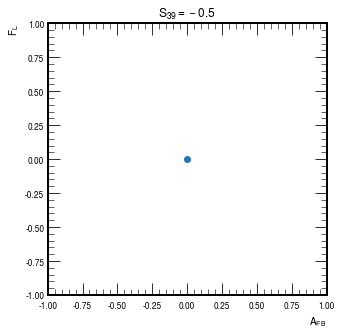

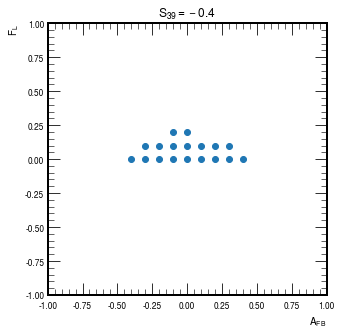

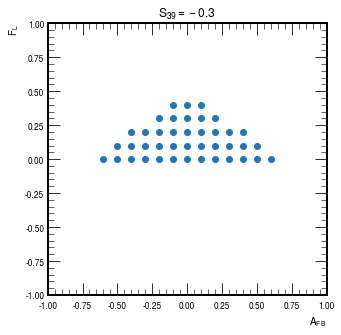

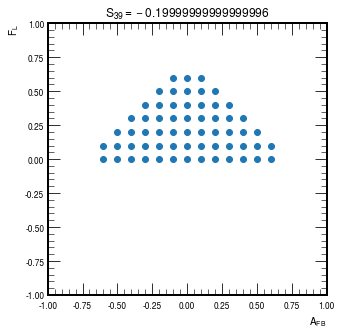

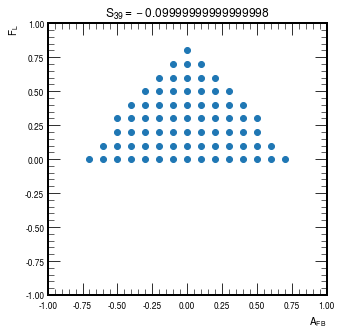

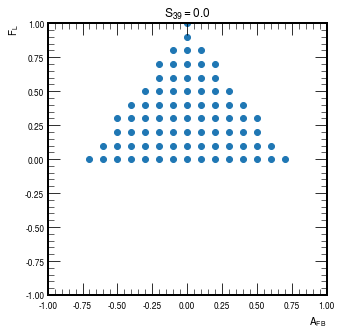

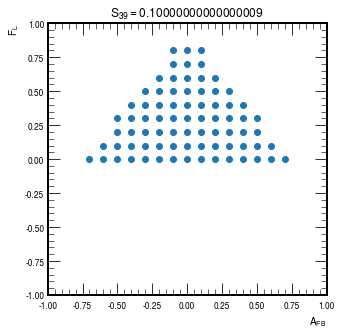

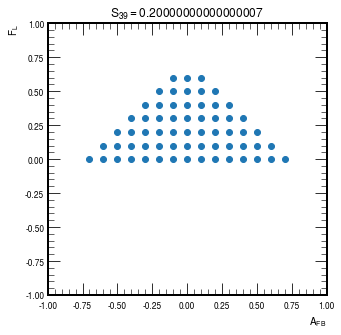

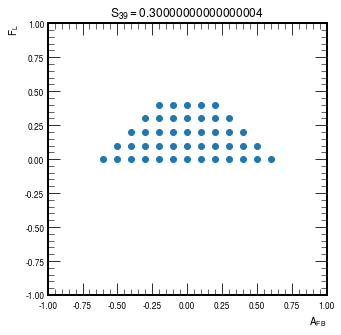

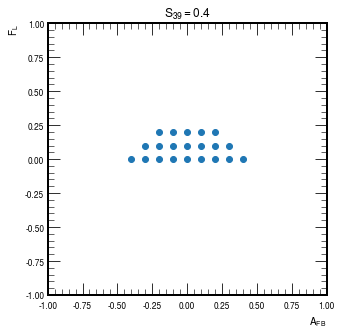

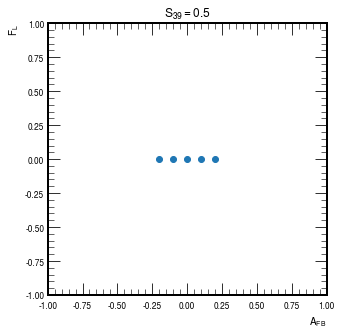

--- 3.852454662322998 seconds ---


In [30]:
start_time = time.time()
valid_coordinates = []
for s39 in S39_np:
    valid_coordinates += calculating_valid_pdfs(s39)
#calculating_valid_pdfs(S39_np[2])
print("--- %s seconds ---" % (time.time() - start_time))

In [31]:
valid_coordinates

[(0.0, 0.0, -0.5),
 (-0.3999999999999999, 0.0, -0.4),
 (-0.29999999999999993, 0.0, -0.4),
 (-0.29999999999999993, 0.10000000000000009, -0.4),
 (-0.19999999999999996, 0.0, -0.4),
 (-0.19999999999999996, 0.10000000000000009, -0.4),
 (-0.09999999999999998, 0.0, -0.4),
 (-0.09999999999999998, 0.10000000000000009, -0.4),
 (-0.09999999999999998, 0.20000000000000018, -0.4),
 (0.0, 0.0, -0.4),
 (0.0, 0.10000000000000009, -0.4),
 (0.0, 0.20000000000000018, -0.4),
 (0.10000000000000009, 0.0, -0.4),
 (0.10000000000000009, 0.10000000000000009, -0.4),
 (0.20000000000000018, 0.0, -0.4),
 (0.20000000000000018, 0.10000000000000009, -0.4),
 (0.30000000000000004, 0.0, -0.4),
 (0.30000000000000004, 0.10000000000000009, -0.4),
 (0.40000000000000013, 0.0, -0.4),
 (-0.6, 0.0, -0.3),
 (-0.5, 0.0, -0.3),
 (-0.5, 0.10000000000000009, -0.3),
 (-0.3999999999999999, 0.0, -0.3),
 (-0.3999999999999999, 0.10000000000000009, -0.3),
 (-0.3999999999999999, 0.20000000000000018, -0.3),
 (-0.29999999999999993, 0.0, -0.3),

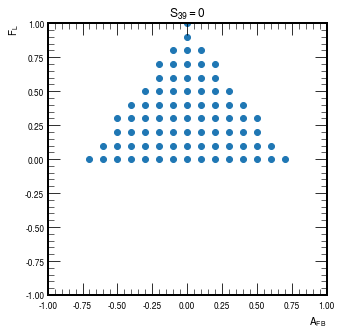

[(-0.7, 0.0, 0),
 (-0.6, 0.0, 0),
 (-0.6, 0.10000000000000009, 0),
 (-0.5, 0.0, 0),
 (-0.5, 0.10000000000000009, 0),
 (-0.5, 0.20000000000000018, 0),
 (-0.5, 0.30000000000000004, 0),
 (-0.3999999999999999, 0.0, 0),
 (-0.3999999999999999, 0.10000000000000009, 0),
 (-0.3999999999999999, 0.20000000000000018, 0),
 (-0.3999999999999999, 0.30000000000000004, 0),
 (-0.3999999999999999, 0.40000000000000013, 0),
 (-0.29999999999999993, 0.0, 0),
 (-0.29999999999999993, 0.10000000000000009, 0),
 (-0.29999999999999993, 0.20000000000000018, 0),
 (-0.29999999999999993, 0.30000000000000004, 0),
 (-0.29999999999999993, 0.40000000000000013, 0),
 (-0.29999999999999993, 0.5, 0),
 (-0.19999999999999996, 0.0, 0),
 (-0.19999999999999996, 0.10000000000000009, 0),
 (-0.19999999999999996, 0.20000000000000018, 0),
 (-0.19999999999999996, 0.30000000000000004, 0),
 (-0.19999999999999996, 0.40000000000000013, 0),
 (-0.19999999999999996, 0.5, 0),
 (-0.19999999999999996, 0.6000000000000001, 0),
 (-0.1999999999999999

In [32]:
calculating_valid_pdfs(0)

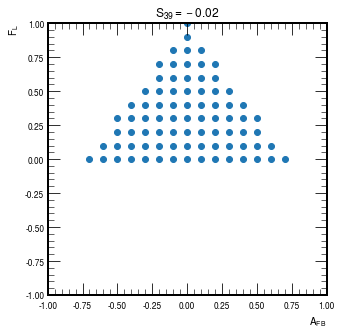

[(-0.7, 0.0, -0.02),
 (-0.6, 0.0, -0.02),
 (-0.6, 0.10000000000000009, -0.02),
 (-0.5, 0.0, -0.02),
 (-0.5, 0.10000000000000009, -0.02),
 (-0.5, 0.20000000000000018, -0.02),
 (-0.5, 0.30000000000000004, -0.02),
 (-0.3999999999999999, 0.0, -0.02),
 (-0.3999999999999999, 0.10000000000000009, -0.02),
 (-0.3999999999999999, 0.20000000000000018, -0.02),
 (-0.3999999999999999, 0.30000000000000004, -0.02),
 (-0.3999999999999999, 0.40000000000000013, -0.02),
 (-0.29999999999999993, 0.0, -0.02),
 (-0.29999999999999993, 0.10000000000000009, -0.02),
 (-0.29999999999999993, 0.20000000000000018, -0.02),
 (-0.29999999999999993, 0.30000000000000004, -0.02),
 (-0.29999999999999993, 0.40000000000000013, -0.02),
 (-0.29999999999999993, 0.5, -0.02),
 (-0.19999999999999996, 0.0, -0.02),
 (-0.19999999999999996, 0.10000000000000009, -0.02),
 (-0.19999999999999996, 0.20000000000000018, -0.02),
 (-0.19999999999999996, 0.30000000000000004, -0.02),
 (-0.19999999999999996, 0.40000000000000013, -0.02),
 (-0.19999

In [33]:
calculating_valid_pdfs(-0.02)

In [34]:
#dr_pdf

In [35]:
# Testing Marlon's values
# FL, S39, AFB, cos(theta_k), cos(theta_l), phi
test_list = [
    (0, 0, 0, cos(pi/3), cos(pi/3), pi/3), 
    (0.4, 0.8, 0.3, cos(pi/3), cos(pi/3), pi/3), 
    (0.4, 0.8, -0.3, cos(pi/3), cos(pi/3), pi/3),
    (-1, 0, 0, cos(pi/4), cos(pi/3), 3*pi/4),
    (-0.4, 0.5, 0.2, cos(pi), cos(pi/3), pi/3),
    (0.3, -0.5, 0.2, cos(pi), cos(pi/3), pi/3)
                ]
results = []
for config in test_list:
    FL.set_value(config[0])
    S39.set_value(config[1])
    AFB.set_value(config[2])
    value = decay_rate.pdf([[config[3], config[4], config[5]]])
    results.append(value.numpy()[0])
results

Estimated integral error ( 3.3813909976622394e-06 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).
Estimated integral error ( 5.4004526750185066e-06 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increas

[0.0839293774816686,
 0.06378648408327009,
 0.010071498773259933,
 -0.022381176175029598,
 -0.1074298076586247,
 0.0805723260469386]

In [36]:
valid_pdfs = np.load('np_arrays/afb_-1_1_fl_-1_1_s39-0.50.npy')
#valid_pdfs = np.load('np_arrays/afb_-1_1_fl_-1_1_s39--0.50.npy')
#valid_pdfs = np.load('np_arrays/afb_-1_1_fl_-1_1_s39-0.00.npy')

In [37]:
valid_points_FL = []
valid_points_AFB = []

for i, vnp_afb in enumerate(valid_pdfs):
    for j, vnp_fl in enumerate(vnp_afb):
        if vnp_fl==True:
            valid_points_FL.append(FL_np[j])
            valid_points_AFB.append(AFB_np[i])

print(valid_points_AFB)
print(valid_points_FL)

[-0.19999999999999996, -0.09999999999999998, 0.0, 0.10000000000000009, 0.20000000000000018]
[0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
S39.set_value(-0.5)
AFB.set_value(-0.8)
FL.set_value(-0.8)
decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit
dr_pdf = decay_rate.pdf(complete_space_np)
print(evaluate_validity_pdf(dr_pdf))


Estimated integral error ( 1.3449967475735167e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).
PDF invalid at
cosThetaK[0] = -1.0
cosThetaL[1] = -0.7777777777777778
phi[0] = 0.0
value = -0.11317612718250158
False


In [39]:
test_list = [
    (0, 0, 0, cos(pi/3), cos(pi/3), pi/3), 
    (0.4, 0.8, 0.3, cos(pi/3), cos(pi/3), pi/3), 
    (0.4, 0.8, -0.3, cos(pi/3), cos(pi/3), pi/3),
    (-1, 0, 0, cos(pi/4), cos(pi/3), 3*pi/4),
    (-0.4, 0.5, 0.2, cos(pi), cos(pi/3), pi/3),
    (0.3, -0.5, 0.2, cos(pi), cos(pi/3), pi/3)
                ]

## Plotting in 3D the constraints

In [40]:
valid_coordinates_np = np.array(valid_coordinates)
#valid_coordinates_np[:,2]

In [41]:
#!pip install ipympl

In [42]:
%matplotlib widget

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

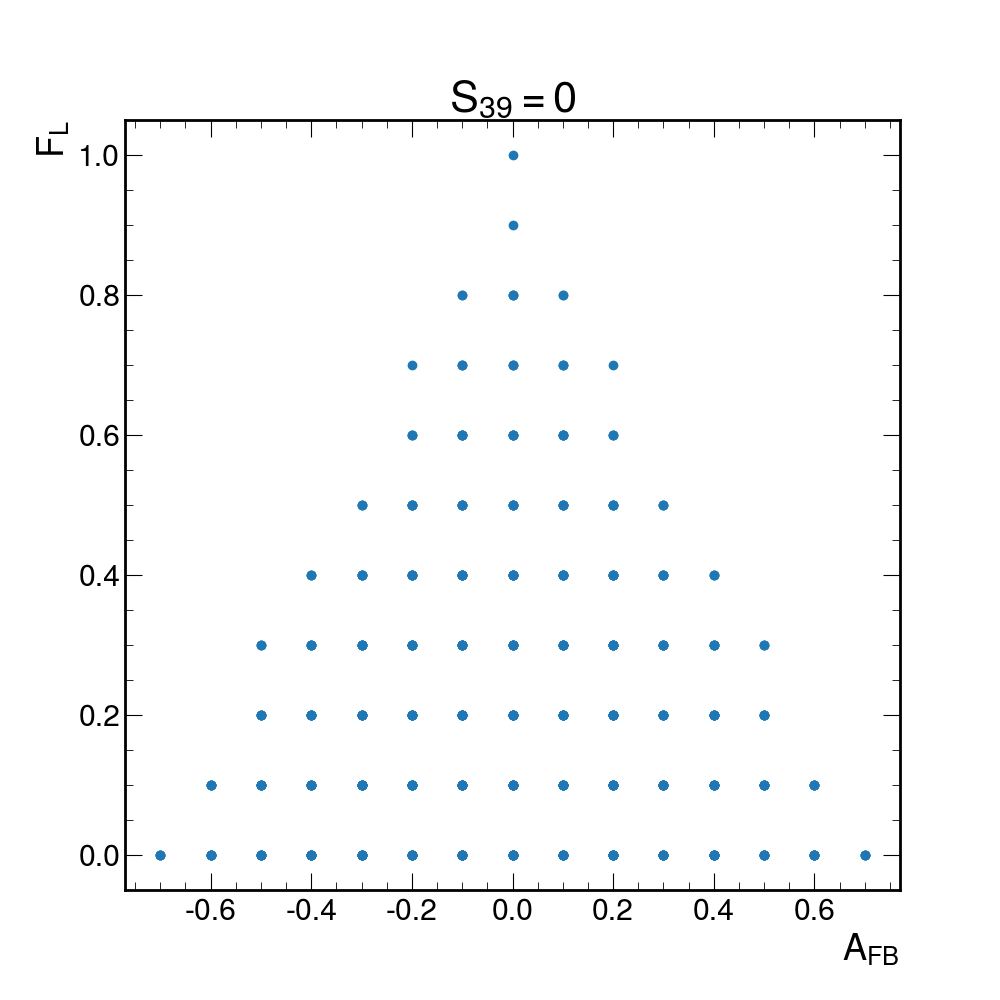

In [43]:
fig = plt.figure()
plt.scatter(valid_coordinates_np[:,0], valid_coordinates_np[:,1])
plt.ylabel('$F_{L}$')
plt.xlabel('$A_{FB}$')
plt.title('$S_{39}=0$')
plt.plot

Text(0.5, 1.0, '$F_{L}=0$')

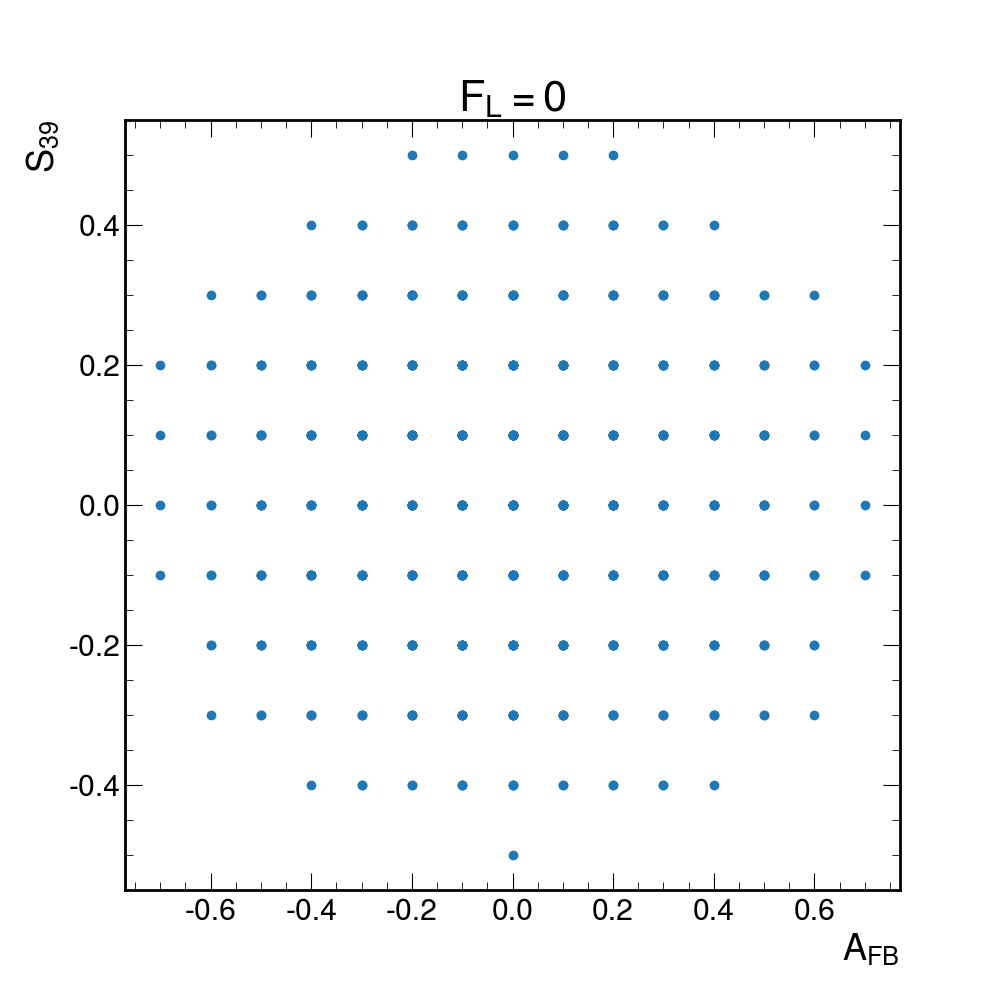

In [44]:
fig = plt.figure()
plt.scatter(valid_coordinates_np[:,0], valid_coordinates_np[:,2])
plt.xlabel('$A_{FB}$')
plt.ylabel('$S_{39}$')
plt.title('$F_{L}=0$')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

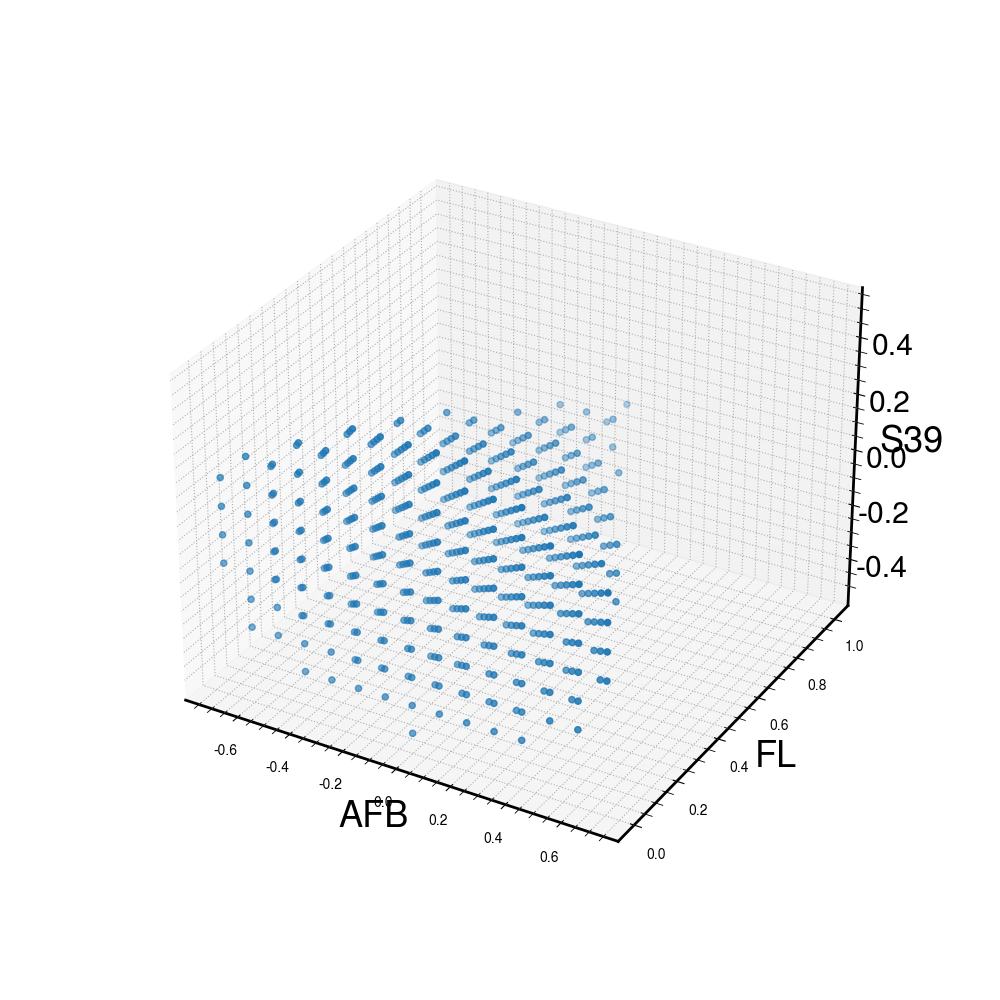

In [45]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(valid_coordinates_np[:,0], valid_coordinates_np[:,1], valid_coordinates_np[:,2], marker='o')

ax.set_xlabel('AFB')
ax.set_ylabel('FL')
ax.set_zlabel('S39')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [46]:
# Defining a function for the possible values
def f(x,y):
    z = np.sqrt(16*x**2/9 + 4*y**2)-1
    return z
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
x = 0.75*np.cos(u)*np.sin(v)
y = 0.5*np.sin(u)*np.sin(v)
z = f(x, y)

In [47]:
x

array([[0.00000000e+00, 2.37959501e-02, 4.75679397e-02, ...,
        4.75679397e-02, 2.37959501e-02, 9.18485099e-17],
       [0.00000000e+00, 2.37480412e-02, 4.74721701e-02, ...,
        4.74721701e-02, 2.37480412e-02, 9.16635892e-17],
       [0.00000000e+00, 2.36045073e-02, 4.71852468e-02, ...,
        4.71852468e-02, 2.36045073e-02, 9.11095715e-17],
       ...,
       [0.00000000e+00, 2.36045073e-02, 4.71852468e-02, ...,
        4.71852468e-02, 2.36045073e-02, 9.11095715e-17],
       [0.00000000e+00, 2.37480412e-02, 4.74721701e-02, ...,
        4.74721701e-02, 2.37480412e-02, 9.16635892e-17],
       [0.00000000e+00, 2.37959501e-02, 4.75679397e-02, ...,
        4.75679397e-02, 2.37959501e-02, 9.18485099e-17]])

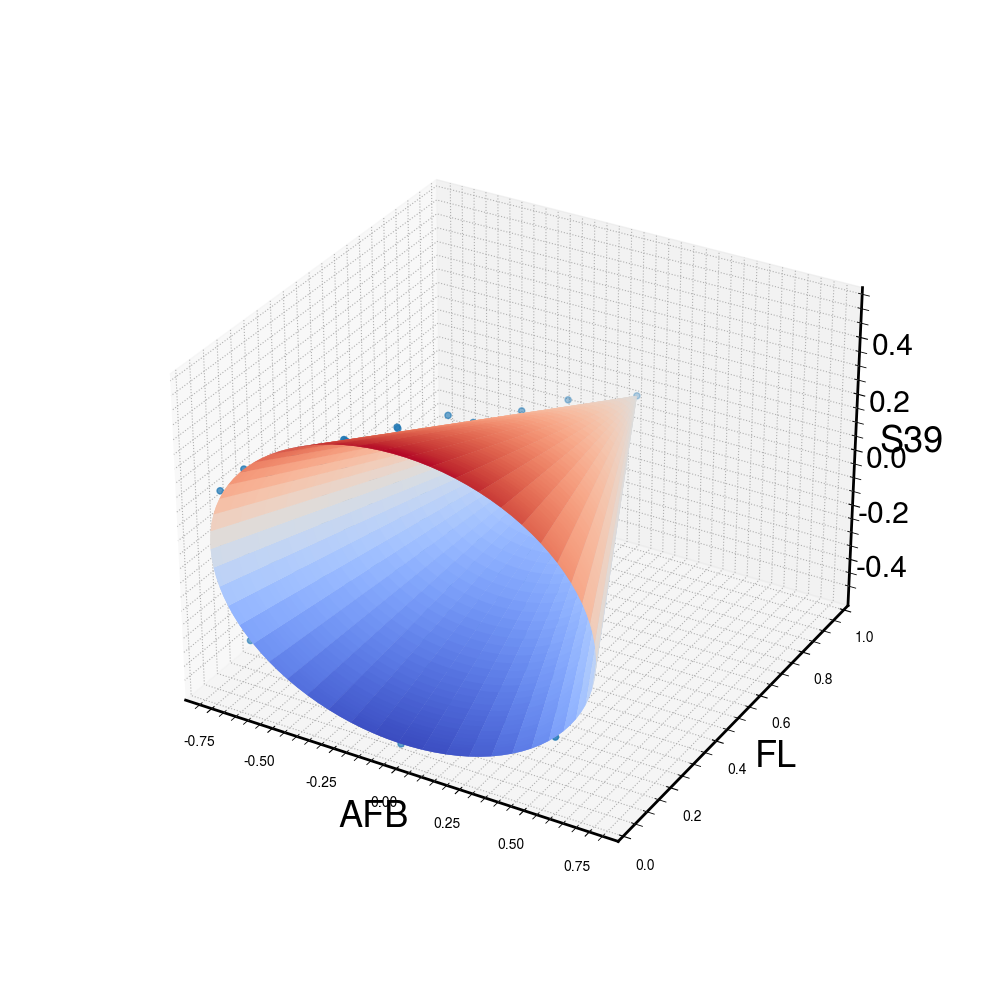

In [50]:
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(valid_coordinates_np[:,0], valid_coordinates_np[:,1], valid_coordinates_np[:,2], marker='o')

ax.set_xlabel('AFB')
ax.set_ylabel('FL')
ax.set_zlabel('S39')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.plot_surface(x, -z, y, cmap=cm.coolwarm)
ax.set_ylim([0, 1])
plt.show()

In [49]:
plt.close()